Dataset Loaded Successfully!
First 5 rows:
      battery_id host_material_id battery_formula framework_formula  \
0   mp-754407_Li        mp-756094       Li1-2FeS2              FeS2   
1  mp-1045431_Zn       mp-1390701     Zn0-0.5CoS2              CoS2   
2     mp-7564_Rb          mp-7564   Rb0-0.5Nb3Te4            Nb3Te4   
3  mp-1041415_Zn       mp-1047798   Zn0-0.5CuMoO4            CuMoO4   
4  mp-1043107_Zn       mp-1043472   Zn0-1NiMoP2O9          NiMoP2O9   

     chemsys formula_anonymous working_ion  nelements  sum_Atomic_Number_WI  \
0       Fe-S               AB2          Li          2                     3   
1       Co-S               AB2          Zn          2                    30   
2      Nb-Te              A3B4          Rb          2                    37   
3    Cu-Mo-O              ABC4          Zn          3                    30   
4  Mo-Ni-O-P            ABC2D9          Zn          4                    30   

   sum_ionic_radius_WI  sum_Pauling_Electronegativity_W

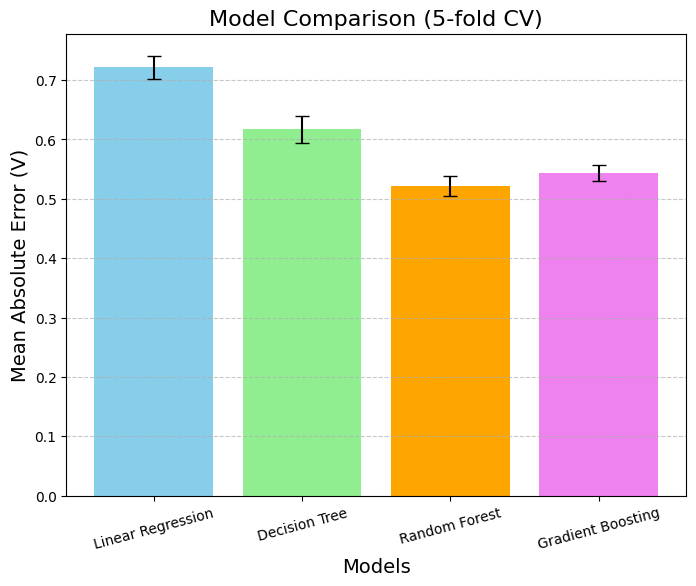

Best model selected: Random Forest

Training the best model: Random Forest ...
Final Test MAE: 0.509 V
Learning curve not available for the selected model.
For demonstration, training a Gradient Boosting Regressor for learning curve analysis...


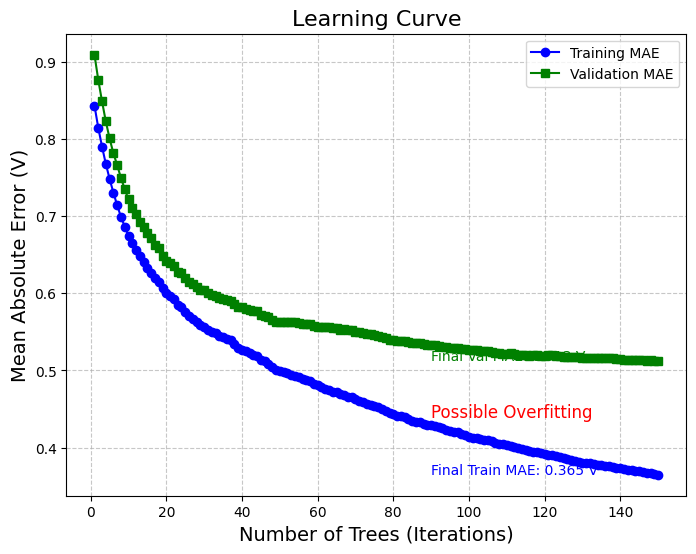

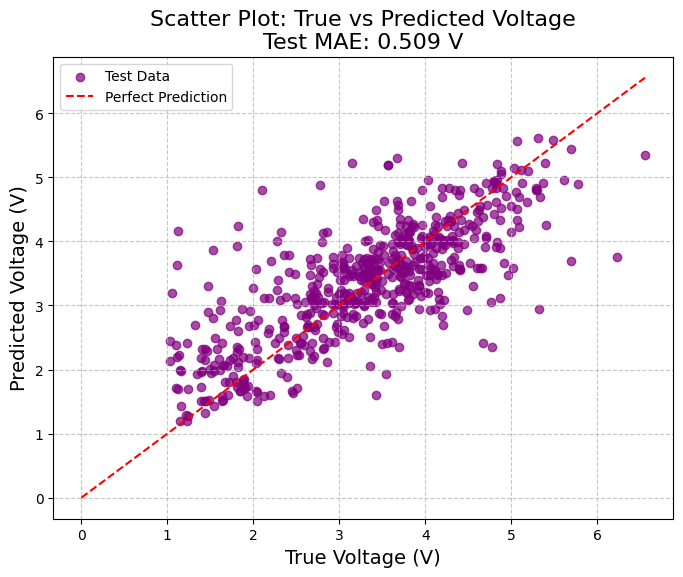

<ipython-input-1-301b4ef07a57>:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


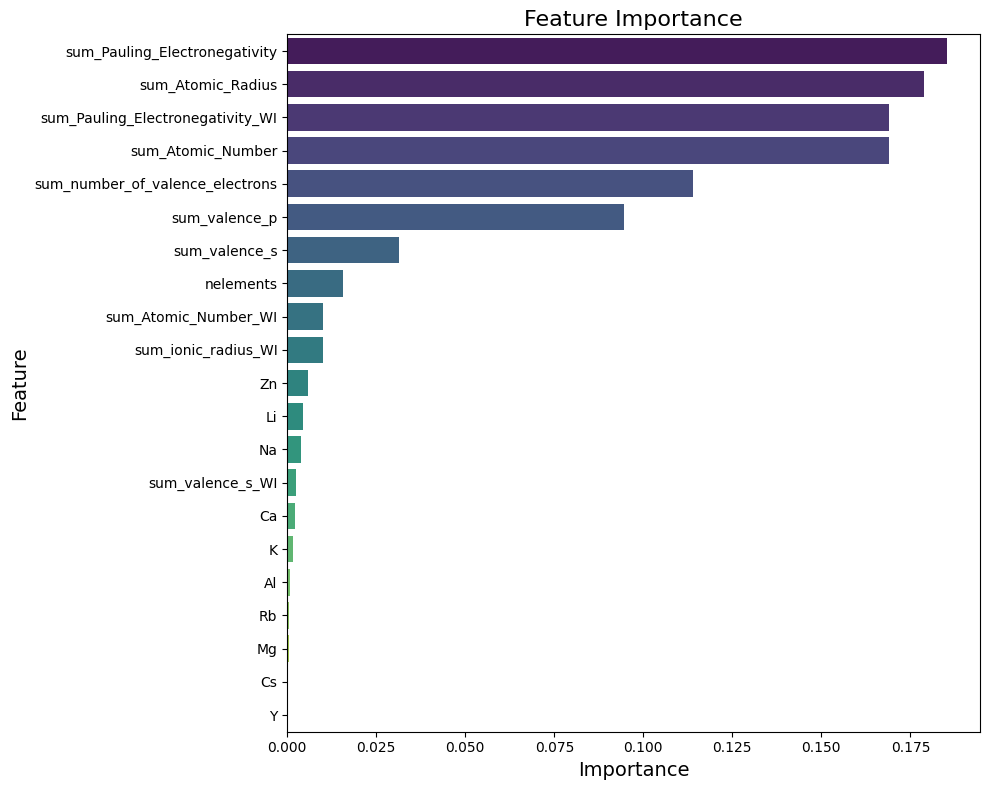

Model saved as best_model.pkl


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

class BatteryML:
    def __init__(self, github_url):
        """
        Initialize the pipeline with the GitHub URL for the dataset.
        """
        self.github_url = github_url
        self.filename = "Battery_data.xlsx"
        self.df = None
        self.x = self.y = None
        self.x_train = self.x_val = self.x_test = None
        self.y_train = self.y_val = self.y_test = None
        self.selected_model = None
        self.selected_model_name = None
        self.train_errors = []  # For learning curve: training errors over iterations
        self.val_errors = []    # For learning curve: validation errors over iterations
        self.cv_results = {}    # CV mean MAE for each model
        self.cv_std = {}        # CV standard deviation for each model

    def download_data(self):
        """
        Download the dataset from GitHub if it doesn't exist locally.
        """
        if not os.path.exists(self.filename):
            print("Downloading dataset from GitHub...")
            os.system(f"wget {self.github_url} -O {self.filename}")
        else:
            print("Dataset already exists. Skipping download.")

    def load_data(self):
        """
        Load the dataset from the Excel file.
        """
        self.df = pd.read_excel(self.filename)
        print("Dataset Loaded Successfully!")
        print("First 5 rows:")
        print(self.df.head())

    def preprocess_data(self):
        """
        Preprocess the dataset by dropping unnecessary columns and performing
        one-hot encoding on the categorical 'working_ion' column.
        """
        df1 = self.df.drop(['battery_id', 'host_material_id', 'battery_formula',
                            'framework_formula', 'chemsys', 'formula_anonymous'], axis=1)
        one_hot = pd.get_dummies(df1['working_ion'])
        df1_encoded = pd.concat([df1, one_hot], axis=1)
        df2 = df1_encoded.drop(['working_ion'], axis=1)
        if df2.isna().sum().sum() > 0:
            print("Missing values detected; dropping rows with NANs.")
            df2 = df2.dropna()
        self.x = df2.drop(['average_voltage'], axis=1)
        self.y = df2['average_voltage']
        print(f"Preprocessing complete. Features shape: {self.x.shape}, Target shape: {self.y.shape}")

    def split_data(self):
        """
        Split the dataset into training (70%), validation (15%), and test (15%) sets.
        """
        x_train, x_temp, y_train, y_temp = train_test_split(self.x, self.y, test_size=0.3, random_state=42)
        x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.x_val, self.y_val = x_val, y_val
        print(f"Data split into:\n - Training: {x_train.shape}\n - Test: {x_test.shape}\n - Validation: {x_val.shape}")

    def model_comparison(self):
        """
        Compare several ML models using 5-fold cross-validation on the training set.
        A bar plot is produced showing the mean MAE (with error bars).
        The model with the lowest mean MAE is selected.
        """
        print("\nComparing models using cross-validation:")
        models = {
            "Linear Regression": LinearRegression(),
            "Decision Tree": DecisionTreeRegressor(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        }
        for name, model in models.items():
            scores = -cross_val_score(model, self.x_train, self.y_train, scoring="neg_mean_absolute_error", cv=5)
            self.cv_results[name] = scores.mean()
            self.cv_std[name] = scores.std()
            print(f"{name}: MAE = {scores.mean():.3f} V ± {scores.std():.3f}")

        plt.figure(figsize=(8,6))
        names = list(self.cv_results.keys())
        means = [self.cv_results[name] for name in names]
        stds = [self.cv_std[name] for name in names]
        plt.bar(names, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'orange', 'violet'])
        plt.ylabel("Mean Absolute Error (V)", fontsize=14)
        plt.xlabel("Models", fontsize=14)
        plt.title("Model Comparison (5-fold CV)", fontsize=16)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=15)
        plt.show()

        # Select the best model based on CV MAE
        self.selected_model_name = min(self.cv_results, key=self.cv_results.get)
        print(f"Best model selected: {self.selected_model_name}")
        if self.selected_model_name == "Linear Regression":
            self.selected_model = LinearRegression()
        elif self.selected_model_name == "Decision Tree":
            self.selected_model = DecisionTreeRegressor()
        elif self.selected_model_name == "Random Forest":
            self.selected_model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif self.selected_model_name == "Gradient Boosting":
            self.selected_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)

    def train_best_model(self):
        """
        Train the selected best model on the training set.
        If the selected model supports staged predictions, its learning curve is plotted.
        Otherwise, for demonstration purposes, a Gradient Boosting Regressor is trained
        to show a learning curve.
        """
        print(f"\nTraining the best model: {self.selected_model_name} ...")
        self.selected_model.fit(self.x_train, self.y_train)
        y_pred_test = self.selected_model.predict(self.x_test)
        test_mae = mean_absolute_error(self.y_test, y_pred_test)
        print(f"Final Test MAE: {test_mae:.3f} V")

        if hasattr(self.selected_model, "staged_predict"):
            self.train_errors = []
            self.val_errors = []
            for y_train_pred, y_val_pred in zip(self.selected_model.staged_predict(self.x_train),
                                                  self.selected_model.staged_predict(self.x_val)):
                self.train_errors.append(mean_absolute_error(self.y_train, y_train_pred))
                self.val_errors.append(mean_absolute_error(self.y_val, y_val_pred))
            self.plot_learning_curve(self.train_errors, self.val_errors)
        else:
            print("Learning curve not available for the selected model.")
            print("For demonstration, training a Gradient Boosting Regressor for learning curve analysis...")
            gbr_model = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42)
            gbr_model.fit(self.x_train, self.y_train)
            train_errs = []
            val_errs = []
            for y_train_pred, y_val_pred in zip(gbr_model.staged_predict(self.x_train),
                                                  gbr_model.staged_predict(self.x_val)):
                train_errs.append(mean_absolute_error(self.y_train, y_train_pred))
                val_errs.append(mean_absolute_error(self.y_val, y_val_pred))
            self.plot_learning_curve(train_errs, val_errs)

    def plot_learning_curve(self, train_errors, val_errors):
        """
        Plot a detailed learning curve showing training and validation MAE over iterations.
        Annotate final errors and indicate any potential overfitting.
        """
        iterations = range(1, len(train_errors) + 1)
        plt.figure(figsize=(8,6))
        plt.plot(iterations, train_errors, label="Training MAE", color="blue", marker="o")
        plt.plot(iterations, val_errors, label="Validation MAE", color="green", marker="s")
        plt.xlabel("Number of Trees (Iterations)", fontsize=14)
        plt.ylabel("Mean Absolute Error (V)", fontsize=14)
        plt.title("Learning Curve", fontsize=16)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        final_train = train_errors[-1]
        final_val = val_errors[-1]
        plt.text(iterations[-1]*0.6, final_train, f"Final Train MAE: {final_train:.3f} V", color="blue")
        plt.text(iterations[-1]*0.6, final_val, f"Final Val MAE: {final_val:.3f} V", color="green")
        if final_train + 0.1 < final_val:
            plt.text(iterations[-1]*0.6, (final_train+final_val)/2, "Possible Overfitting", color="red", fontsize=12)
        plt.show()

    def plot_scatter(self):
        """
        Plot a scatter plot of true vs. predicted values on the test set.
        The plot includes a diagonal line indicating perfect predictions and annotates the test MAE.
        """
        y_pred = self.selected_model.predict(self.x_test)
        test_mae = mean_absolute_error(self.y_test, y_pred)
        plt.figure(figsize=(8,6))
        plt.scatter(self.y_test, y_pred, color='purple', alpha=0.7, label="Test Data", marker='o')
        max_val = max(np.max(self.y_test), np.max(y_pred))
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label="Perfect Prediction")
        plt.xlabel("True Voltage (V)", fontsize=14)
        plt.ylabel("Predicted Voltage (V)", fontsize=14)
        plt.title(f"Scatter Plot: True vs Predicted Voltage\nTest MAE: {test_mae:.3f} V", fontsize=16)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def feature_importance(self):
        """
        Plot feature importances if provided by the model.
        """
        if hasattr(self.selected_model, "feature_importances_"):
            importance_df = pd.DataFrame({
                'Feature': self.x_train.columns,
                'Importance': self.selected_model.feature_importances_
            }).sort_values(by='Importance', ascending=False)
            plt.figure(figsize=(10,8))
            sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
            plt.xlabel("Importance", fontsize=14)
            plt.ylabel("Feature", fontsize=14)
            plt.title("Feature Importance", fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            print("The selected model does not provide feature importances.")

    def save_model(self, filename="best_model.pkl"):
        """
        Save the selected best model to a file.
        """
        joblib.dump(self.selected_model, filename)
        print(f"Model saved as {filename}")

# === Running the Pipeline ===
github_file_url = "https://raw.githubusercontent.com/Souvik-ml/ML-Workshop/main/Battery_data.xlsx"
battery_ml = BatteryML(github_file_url)
battery_ml.download_data()
battery_ml.load_data()
battery_ml.preprocess_data()
battery_ml.split_data()
battery_ml.model_comparison()
battery_ml.train_best_model()
battery_ml.plot_scatter()
battery_ml.feature_importance()
battery_ml.save_model()